In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
import requests
import pandas as pd
import time


In [27]:
# Timestamps pour les 5 dernieres ann√©es
end_time = int(time.time())
start_time = end_time - (5 * 365 * 24 * 60 * 60)  

url = f"https://query1.finance.yahoo.com/v8/finance/chart/BTC-EUR?interval=1d&period1={start_time}&period2={end_time}"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()

    timestamps = data["chart"]["result"][0]["timestamp"]
    open = data["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = data["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = data["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = data["chart"]["result"][0]["indicators"]["quote"][0]["close"]

    df = pd.DataFrame({"date": timestamps, "open": open, "high": high, "low": low, "close": close})
    df["date"] = pd.to_datetime(df["date"], unit="s") 

    df.to_csv("bitcoin_historical_from_2020_to_now.csv", index=False)

    print(df.head())  

else:
    print(f"Erreur {response.status_code}: Impossible de r√©cup√©rer les donn√©es")
    print(response.text)


        date         open         high          low        close
0 2020-02-12  9343.948242  9524.737305  9343.948242  9495.313477
1 2020-02-13  9493.387695  9616.425781  9319.048828  9421.151367
2 2020-02-14  9418.541992  9523.971680  9341.442383  9521.362305
3 2020-02-15  9522.969727  9548.245117  9116.950195  9130.796875
4 2020-02-16  9130.571289  9282.718750  8976.573242  9163.173828


In [28]:
# Chargement des donn√©es
data = pd.read_csv("C:/Users/ethan/OneDrive/Bureau/ESIR 3/IA/bitcoin_historical_from_2020_to_now.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


In [29]:
# Pr√©traitement des donn√©es
features = data.values  # Les colonnes sont dans l'ordre : Ouverture, Plus haut, Plus bas, Volume, Fermer
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Pour X, on prend toutes les colonnes sauf la derni√®re (donc: Ouverture, Plus haut, Plus bas, Volume)
        X.append(data[i:i + sequence_length, :-1])
        # Pour y, on prend la derni√®re colonne, ici "Fermer"
        y.append(data[i + sequence_length, -1])
    return np.array(X), np.array(y)

sequence_length = 120
X, y = create_sequences(scaled_data, sequence_length)


C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


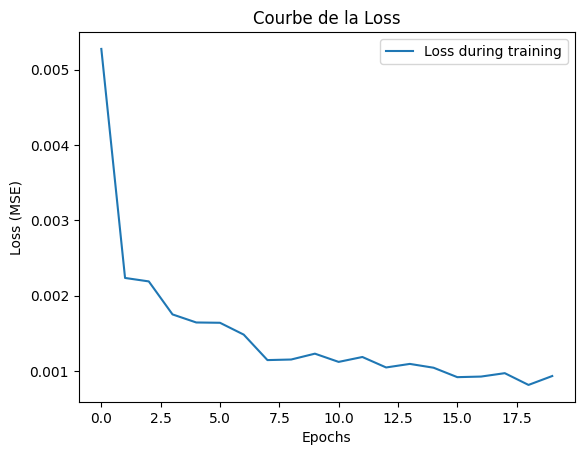

Erreur Quadratique Moyenne (MSE) sur l'ensemble de test: 14710433.408087522


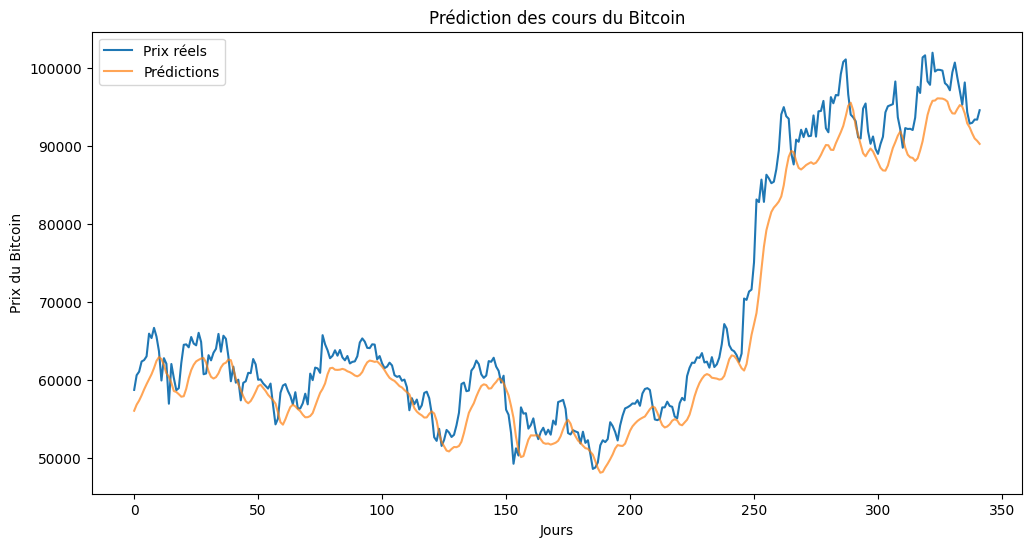

In [30]:
# Division des ensembles d'entra√Ænement et de test (80% entra√Ænement, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Classe personnalis√©e pour le mod√®le GRU
class GRUModel(BaseEstimator, RegressorMixin):
    def __init__(self, units=50, dropout=0.2, optimizer='adam', batch_size=32, epochs=10):
        self.units = units
        self.dropout = dropout
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
        self.history = None  # Pour enregistrer l'historique de l'entra√Ænement

    def build_model(self):
        model = Sequential([
            GRU(self.units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
            Dropout(self.dropout),
            GRU(self.units, return_sequences=False),
            Dropout(self.dropout),
            Dense(1)
        ])
        model.compile(optimizer=self.optimizer, loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        # Entra√Ænement avec retour de l'historique
        self.history = self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=0)

# Meilleurs hyperparam√®tres trouv√©s (par exemple via GridSearchCV)
best_params = {
    'batch_size': 32,
    'dropout': 0.3,
    'epochs': 20,
    'optimizer': 'rmsprop',
    'units': 50
}

# Entra√Ænement du mod√®le avec les meilleurs hyperparam√®tres
best_model = GRUModel(
    units=best_params['units'],
    dropout=best_params['dropout'],
    optimizer=best_params['optimizer'],
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs']
)

best_model.fit(X_train, y_train)

# Trac√© de la courbe de la perte pendant l'entra√Ænement
plt.plot(best_model.history.history['loss'], label='Loss during training')
plt.title('Courbe de la Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Pr√©diction sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Pour inverser la normalisation, on reconstruit un tableau √† 5 colonnes :
# Les 4 premi√®res colonnes proviennent du dernier pas de temps de la s√©quence d'entr√©e
# La 5√®me colonne est la valeur cible (Volume) (y ou y_pred)
# IMPORTANT : On utilise X_test[:, -1, :] et non X_test[:, -1, :-1] afin d'obtenir les 4 features d'origine.
X_test_last_feature = X_test[:, -1, :]  # Shape attendue : (n_samples, 4)

# Concat√©nation avec y_test pour obtenir un tableau (n_samples, 5)
y_test_with_features = np.concatenate([X_test_last_feature, y_test.reshape(-1, 1)], axis=1)

# Inversion de la normalisation pour r√©cup√©rer les valeurs r√©elles du Volume
y_test_inv = scaler.inverse_transform(y_test_with_features)[:, -1]

# Idem pour les pr√©dictions
y_pred_with_features = np.concatenate([X_test_last_feature, y_pred.reshape(-1, 1)], axis=1)
y_pred_inv = scaler.inverse_transform(y_pred_with_features)[:, -1]

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Erreur Quadratique Moyenne (MSE) sur l'ensemble de test: {mse}")

# Visualisation des r√©sultats
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Prix r√©els')
plt.plot(y_pred_inv, label='Pr√©dictions', alpha=0.7)
plt.title('Pr√©diction des cours du Bitcoin')
plt.xlabel('Jours')
plt.ylabel('Prix du Bitcoin')
plt.legend()
plt.show()

In [31]:
# Pr√©diction pour le lendemain

# On cr√©e la derni√®re s√©quence √† partir des derni√®res 60 observations.
# Ici, on prend les features d'entr√©e (toutes les colonnes sauf la cible, c'est-√†-dire la derni√®re colonne).
last_sequence = scaled_data[-sequence_length:, :-1]  # shape: (60, n_features)
last_sequence = np.expand_dims(last_sequence, axis=0)   # reshape en (1, sequence_length, n_features)

# Pr√©diction √† l'√©chelle normalis√©e
next_day_scaled = best_model.predict(last_sequence)  # Renvoie un tableau de forme (1, 1)

# Pour inverser la normalisation, on reconstruit une ligne de donn√©es
# qui respecte le format d'origine utilis√© lors de l'ajustement du scaler.
# On r√©cup√®re le dernier jeu de features de la s√©quence (correspondant aux autres colonnes)
# et on y concat√®ne la valeur pr√©dite.
last_features = last_sequence[0, -1, :]              # shape: (n_features,)
next_day_row = np.concatenate([last_features, next_day_scaled[0]])  # shape: (n_columns,)
next_day_row = next_day_row.reshape(1, -1)

# Inversion de la normalisation pour obtenir la pr√©diction dans l'√©chelle d'origine.
next_day_price = scaler.inverse_transform(next_day_row)[0, -1]

print(f"Le cours pr√©dit pour demain est : {next_day_price}")


Le cours pr√©dit pour demain est : 90173.27678792346


Shape de X_test[:, -1, :] (342, 3)
Nombre de features disponibles : 3


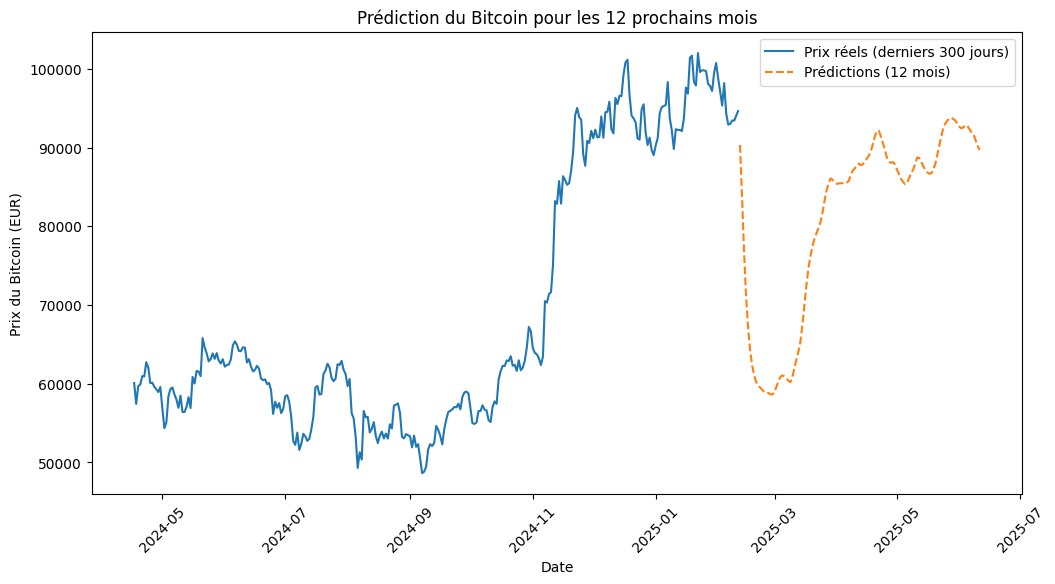

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Nombre de jours √† pr√©dire (12 mois)
future_days = 120

# Derni√®re s√©quence connue
last_sequence = X_test[-1]  # Derni√®re s√©quence de 60 jours

# Liste pour stocker les futures pr√©dictions
future_predictions = []

# G√©n√©ration de la pr√©diction jour par jour
for _ in range(future_days):
    # Pr√©dire la prochaine valeur
    next_pred = best_model.predict(np.expand_dims(last_sequence, axis=0))[0][0]

    # Ajouter la pr√©diction √† la liste
    future_predictions.append(next_pred)

    # Mise √† jour de la s√©quence
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1, -1] = next_pred

# üîπ **Correction : V√©rification du nombre r√©el de features**
print("Shape de X_test[:, -1, :]", X_test[:, -1, :].shape)  # Debugging

# R√©cup√©ration des valeurs moyennes des features disponibles
last_known_features = np.mean(X_test[:, -1, :], axis=0)  # Prendre toutes les features

# V√©rification du nombre de colonnes
print(f"Nombre de features disponibles : {last_known_features.shape[0]}")

# Cr√©ation d'un tableau avec les features + 1 target (prix pr√©diction)
future_predictions_with_features = np.column_stack([
    np.tile(last_known_features, (future_days, 1)),  # R√©p√©ter les features disponibles
    np.array(future_predictions).reshape(-1, 1)  # Valeur cible pr√©dite
])

# Inversion de la normalisation
future_predictions_real = scaler.inverse_transform(future_predictions_with_features)[:, -1]

# G√©n√©rer les dates pour la pr√©diction
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=future_days + 1)[1:]

# Trac√© des pr√©dictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[-300:], data['close'].values[-300:], label="Prix r√©els (derniers 300 jours)")
plt.plot(future_dates, future_predictions_real, label="Pr√©dictions (12 mois)", linestyle="dashed")
plt.title("Pr√©diction du Bitcoin pour les 12 prochains mois")
plt.xlabel("Date")
plt.ylabel("Prix du Bitcoin (EUR)")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [36]:
import numpy as np
import pandas as pd

# üîπ D√©finition des param√®tres
initial_balance = 10.0  # D√©part avec 10‚Ç¨
balance = initial_balance
bitcoin_held = 0  # Nombre de BTC poss√©d√©s
transaction_history = []  # Stocke les transactions pour analyse

# üîπ Simulation sur la p√©riode de test
for i in range(len(y_pred_inv) - 1):
    predicted_price_today = y_pred_inv[i]  # Prix pr√©dit pour aujourd'hui
    predicted_price_tomorrow = y_pred_inv[i + 1]  # Prix pr√©dit pour demain
    real_price_today = y_test_inv[i]  # Prix r√©el aujourd'hui
    real_price_tomorrow = y_test_inv[i + 1]  # Prix r√©el demain

    # üîπ D√©cision d'achat
    if predicted_price_tomorrow > predicted_price_today and balance > 0:
        bitcoin_held = balance / real_price_today  # Acheter BTC avec tout l'argent
        balance = 0  # Plus d'argent liquide
        transaction_history.append(("BUY", real_price_today, bitcoin_held))

    # üîπ D√©cision de vente
    elif predicted_price_tomorrow < predicted_price_today and bitcoin_held > 0:
        balance = bitcoin_held * real_price_today  # Vendre tous les BTC
        bitcoin_held = 0  # Plus de BTC en portefeuille
        transaction_history.append(("SELL", real_price_today, balance))

# üîπ Valeur finale du portefeuille (si on d√©tient encore des BTC)
if bitcoin_held > 0:
    balance = bitcoin_held * y_test_inv[-1]

# üîπ Affichage des r√©sultats
print(f"Balance initiale : {initial_balance}‚Ç¨")
print(f"Balance finale : {balance:.2f}‚Ç¨")
print(f"Performance totale : {((balance / initial_balance) - 1) * 100:.2f}%")

# üîπ Affichage des transactions
df_transactions = pd.DataFrame(transaction_history, columns=["Type", "Prix BTC", "Valeur"])
print("\nHistorique des transactions :")
print(df_transactions)


Balance initiale : 10.0‚Ç¨
Balance finale : 13.29‚Ç¨
Performance totale : 32.93%

Historique des transactions :
    Type       Prix BTC     Valeur
0    BUY   58772.386719   0.000170
1   SELL   63730.011719  10.843530
2    BUY   62211.914063   0.000174
3   SELL   60778.117187  10.593619
4    BUY   63535.992187   0.000167
5   SELL   63046.519531  10.512007
6    BUY   60956.074219   0.000172
7   SELL   60111.652344  10.366385
8    BUY   59332.816406   0.000175
9   SELL   56935.683594   9.947568
10   BUY   58284.734375   0.000171
11  SELL   63137.343750  10.775772
12   BUY   63159.015625   0.000171
13  SELL   62938.316406  10.738118
14   BUY   63082.285156   0.000170
15  SELL   64128.632812  10.916231
16   BUY   64581.773438   0.000169
17  SELL   62692.382813  10.596868
18   BUY   58385.769531   0.000181
19  SELL   55762.273438  10.120710
20   BUY   53304.867188   0.000190
21  SELL   53014.199219  10.065523
22   BUY   54239.234375   0.000186
23  SELL   60313.636719  11.192789
24   BUY   62